# COVID-19 Development in Hamburg, Germany

This notebook will show the development of COVID-19 in Hamburg.

## Source of the data

[Hamburg.jl](https://github.com/oem/Hamburg.jl) provides information to all the datasources used. To summarize: The datasources are all "official" and either from the RKI or the official corona page of the city of Hamburg.

In [1]:
using Hamburg

In [2]:
using Dates, DataFrames, TimeSeries, StatsPlots, Statistics

gr(size=(800,400))
Plots.theme(:vibrant)

infected = dataset("covid-19", "infected")
DataFrames.head(infected, 5)

,deaths,hospitalizations,intensivecare,new,recordedat,recovered,total
,Int64?,Int64?,Int64?,Int64,Date,Int64?,Int64
1,241,58,15,168,2020-10-15,7400,9455
2,241,62,14,135,2020-10-14,7300,9287
3,241,62,14,114,2020-10-13,7200,9152
4,241,60,12,77,2020-10-12,7200,9040
5,241,60,12,52,2020-10-11,7100,8963


## New cases

### Looking at the last seven days: lockdown or not

The senate will need to decide on stricter measures if there are **950 or more** new cases in the last seven days.

In [3]:
lastweek = infected[1:7, :]
sumlastweek = sum(lastweek.new)
print("$sumlastweek of 950 new cases in the last seven days.")

789 of 950 new cases in the last seven days.

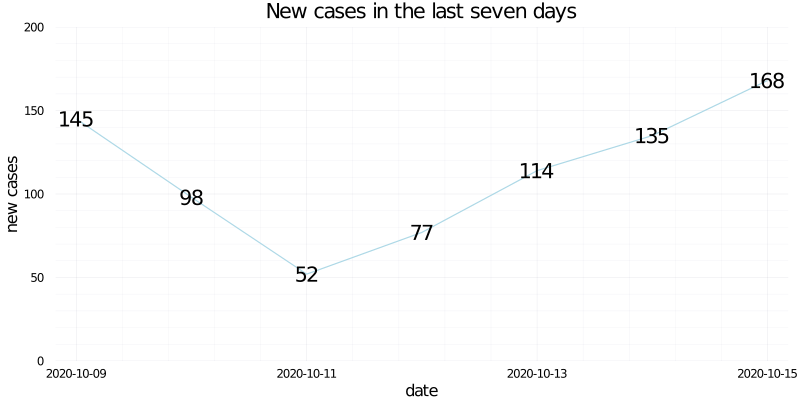

In [4]:
taweek = TimeArray(lastweek, timestamp=:recordedat)
plot(taweek[:new];
    c=:lightblue,
    linecolor=:lightblue,
    label=false,
    series_annotations=reverse(string.(lastweek.new)),
    title="New cases in the last seven days",
    ylabel="new cases",
    xlabel="date",
    ylim=(0, 200),
    size=(800, 400))

### Looking at the development of new cases over the whole course of the pandemic

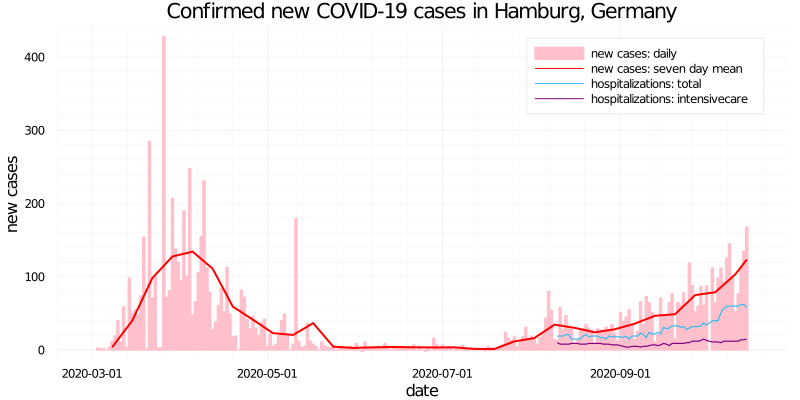

In [5]:
ta = TimeArray(infected.recordedat, convert.(Float64, infected.new), [:new])
collapsed = collapse(ta, week, last, mean)

@df infected bar(reverse(infected.recordedat), reverse(infected.new),
    linecolor=:pink,
    title="Confirmed new COVID-19 cases in Hamburg, Germany",
    ylabel="new cases",
    xlabel="date", 
    label="new cases: daily",
    c=:pink,
    size=(800, 400))

plot!(collapsed, c=:red, label="new cases: seven day mean", lw=2)
plot!(reverse(infected.recordedat), reverse(infected.hospitalizations), label="hospitalizations: total")
plot!(reverse(infected.recordedat), reverse(infected.intensivecare), label="hospitalizations: intensivecare", c=:purple)

## Development in the boroughs

There is even more fine-grained data available showing the development of COVID-19 for each borough. The numbers are aggregated into 14 day intervals. The aggregation happens to protect the privacy of the affected people.

In [6]:
boroughsovertime = dataset("covid-19", "boroughs")
boroughs = select(boroughsovertime, Not(:recordedat))
boroughsmatrix = convert(Matrix, boroughs)
boroughsovertime

,Altona,Bergedorf,Eimsbüttel,Hamburg Mitte,Hamburg Nord,Harburg,Wandsbek,recordedat
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Date
1,93,55,67,156,90,60,181,2020-10-12
2,63,39,58,94,109,70,156,2020-10-05
3,69,28,65,97,92,46,123,2020-09-28
4,79,31,83,98,143,43,181,2020-09-21
5,88,23,72,87,126,41,105,2020-09-14
6,79,17,59,88,90,21,73,2020-09-07
7,47,17,43,86,58,22,74,2020-08-31
8,49,15,38,111,36,39,67,2020-08-24
9,64,11,48,150,43,54,83,2020-08-17


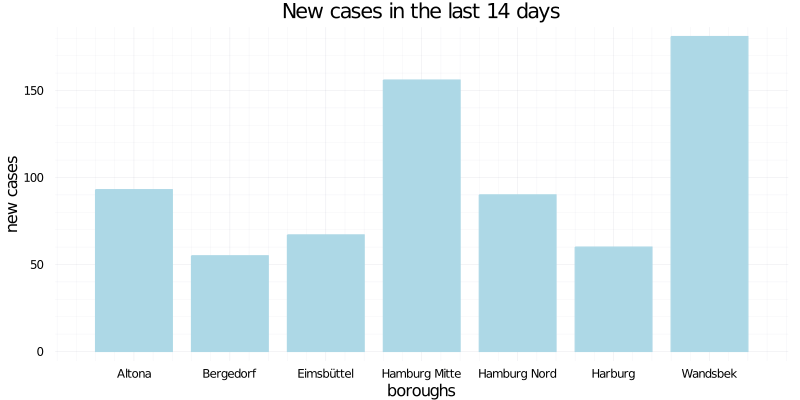

In [7]:
bar(names(boroughs), boroughsmatrix[1, :],
    legend=false, 
    c=:lightblue, 
    linecolor=:lightblue, 
    size=(800,400), 
    title="New cases in the last 14 days", 
    xlabel="boroughs", 
    ylabel="new cases")

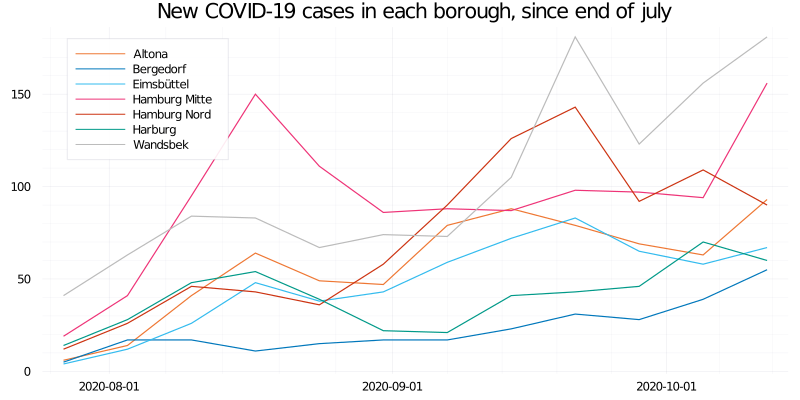

In [8]:
tb = TimeArray(boroughsovertime, timestamp=:recordedat)

plot(tb, legend=:topleft, size=(800,400))
plot!(title="New COVID-19 cases in each borough, since end of july")